## **ProStockAI by DataCrafters**



In [ ]:
# @title **Importing Libraries**
import requests
import pandas as pd
import io
import json
from urllib.request import Request, urlopen
import numpy as np
import matplotlib.pyplot as plt
import warnings
import yfinance as yf
from termcolor import colored
plt.style.use('fivethirtyeight')

In [ ]:
# @title  **User request**


In [ ]:
# @title **importing Stock Prices data**
def get_stock_data(symbol):
    # Use yfinance library to fetch historical stock data
    stock = yf.Ticker(symbol)
    data = stock.history(period="max")
    return data

In [ ]:
# @title  **Importing Crypto Prices Data**
def get_price(fsym, tosym='USD', limit=2000):
    headers = {'api_key': '81c1aec9de8ba69f26a1f7cfea7c49a98ba746ce3b526f24ce6d646a9efaf1c3'}
    url = "https://min-api.cryptocompare.com/data/v2/histoday"
    par = {'api_key': '81c1aec9de8ba69f26a1f7cfea7c49a98ba746ce3b526f24ce6d646a9efaf1c3','fsym': fsym, 'tsym':tosym, 'limit':limit}
    r = requests.get(url,par)
    rt = r.json()['Data']['Data']
    df = pd.DataFrame(rt)
    return df

li = # get a list of the user selected stocks
Prices_df = pd.DataFrame(columns = li)
for column in Prices_df:
    Prices_df[column] = get_price(column)['close']
    Prices_df['time'] = get_price(column)['time']

In [ ]:
# @title **Predicted Data**
def calculate_returns(data):
    # Calculate daily returns based on adjusted closing prices
    returns = data['Adj Close'].pct_change().dropna()
    return returns

def create_features(returns, num_lags):
    # Create lagged features by shifting returns
    features = pd.DataFrame(index=returns.index)

    for lag in range(1, num_lags+1):
        features[f'Lag_{lag}'] = returns.shift(lag)

    return features

def train_test_split_data(features, target, test_size):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, shuffle=False)
    return X_train, X_test, y_train, y_test

def train_regression_model(X_train, y_train):
    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def predict_returns(model, X):
    # Predict returns using the trained model
    predicted_returns = model.predict(X)
    return predicted_returns

In [ ]:
# @title **Data Cleaning**
Prices_df['time'] = pd.to_datetime(Prices_df['time'], unit='s', )
Prices_df = Prices_df.set_index('time')
Prices_df

In [ ]:
# @title **Portfolio metrics computing**
# use pct_change() to get the return
crypto_return = Prices_df.pct_change()
# drop inf values
lst = [np.inf, -np.inf]
to_replace = {v: lst for v in crypto_return}
crypto_return = crypto_return.replace(to_replace, np.nan)

# get daily return of the Portfolio by summing the all return
wight = np.array([0.16,0.16,0.16, 0.16,0.16,0.16])
Return  = crypto_return * wight
crypto_return['Return'] = Return.sum(axis=1)

# portfolio annual and total return
annual_return = crypto_return.resample('Y').sum()
total_return = annual_return['Return'].sum()
mean_return = crypto_return['Return'].mean()
print("Portfolio Total Return {:.2%}".format(total_return))
print('Mean Annual Return {:.2%}'.format(np.sum(mean_return * wight) * 365))

# portfolio risk

cov_matrix = crypto_return.iloc[:,:-1].cov() * 365
volatility1 = np.sqrt((np.dot(wight.T, np.dot(cov_matrix,wight))))
print('Portfolio Annual Risk {:.2%}'.format(volatility1))

#plot the annual and daily return
plt.rcParams["figure.figsize"] = (5,5)
warnings.filterwarnings("ignore")
crypto_return['Return'].hist(bins=70, color='midnightblue')
plt.title('Daily Return')
plt.show()
annual_plot = annual_return['Return'].plot(color='midnightblue')
plt.title('Annual Return')
vals = annual_plot.get_yticks()
annual_plot.set_yticklabels(['{:.0%}'.format(x) for x in vals])




Risk_free_rate = 0
annual_return['Sharp ratio'] = (np.sum(mean_return * wight) * 365)-Risk_free_rate / volatility1
Sharpe_ratio1 = annual_return['Sharp ratio'].sort_values(ascending=False).iloc[1]
print('Highest Sharpe Ratio {:.2%}'.format(Sharpe_ratio1))

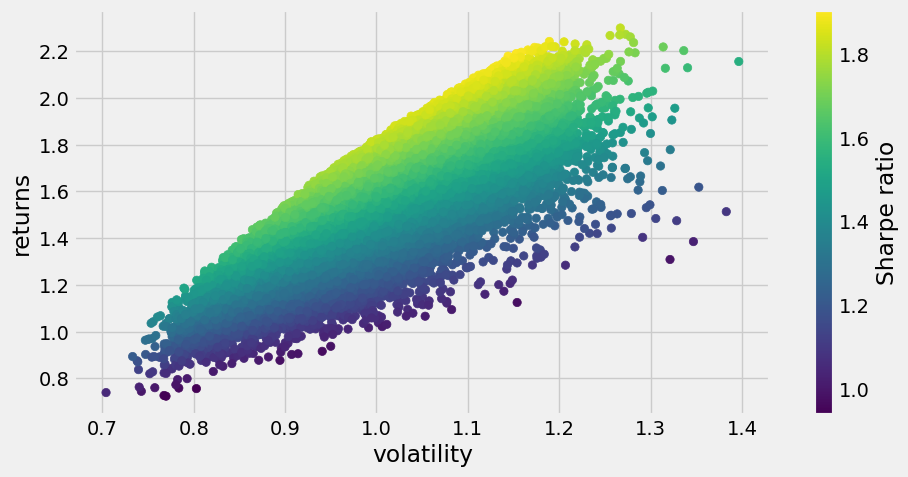

In [ ]:
# @title **Portfolio Optimization/Generating**
# source:https://codingandfun.com/portfolio-optimization-with-python/
number_of_portfolios = 100000
portfolio_returns = []
portfolio_risk = []
sharpe_ratio = []
portfolio_weights = []

for portfolio in range (number_of_portfolios):
    weights = np.random.rand(6)
    weights = weights / np.sum(weights)
    Return  = np.sum((crypto_return.iloc[:,:-1].mean() * weights) * 365)
    cov_matrix = crypto_return.iloc[:,:-1].cov() * 365
    volatility = np.sqrt((np.dot(weights.T, np.dot(cov_matrix,weights))))
    Sharp_ratio = ((Return -Risk_free_rate) / volatility)
    portfolio_returns.append(Return)
    portfolio_risk.append(volatility)
    sharpe_ratio.append(Sharp_ratio)
    portfolio_weights.append(weights)
#convert to arrays
portfolio_risk = np.array(portfolio_risk)
portfolio_returns = np.array(portfolio_returns)
sharpe_ratio = np.array(sharpe_ratio)
plt.figure(figsize=(10, 5))
plt.scatter(portfolio_risk, portfolio_returns, c=portfolio_returns / portfolio_risk)
plt.xlabel('volatility')
plt.ylabel('returns')
plt.colorbar(label='Sharpe ratio')

In [ ]:
# @title **Portfolio Selection**
portfolio = {'Return': portfolio_returns, 'Risk': portfolio_risk, 'Sharpe Ratio':sharpe_ratio, 'weights':portfolio_weights}
portfolio_df = pd.DataFrame(portfolio)
Highest_sharpe_port = portfolio_df.iloc[portfolio_df['Sharpe Ratio'].idxmax()]
#portfolio with the minimum risk
min_risk = portfolio_df.iloc[portfolio_df['Risk'].idxmin()]
pd.set_option('max_colwidth', 800)
print(Highest_sharpe_port)
print(colored('Highest Sharpe Ratio {:.2%}'.format(Highest_sharpe_port['Sharpe Ratio']), 'green',attrs=['bold']))
print(colored('Highest Sharpe Ratio Portfolio Weights ','blue',attrs=['bold']),Highest_sharpe_port['weights'],'\n')
print(colored('Lowest Risk {:.2%}'.format(min_risk['Risk']), 'red',attrs=['bold']))

print(colored('Lowest Risk Portfolio Weights ' ,'blue',attrs=['bold']), min_risk['weights'],'\n')
print(colored('The Efficient Frontier increaced Sharpe Ratio by  {:.2%}'.format(Highest_sharpe_port['Sharpe Ratio']- Sharpe_ratio1 ),'green',attrs=['bold']))
print(colored('The Efficient Frontier Reduced Risk by {:.2%}'.format(min_risk['Risk'] - volatility1 ) ,'green',attrs=['bold']))

Return                                                                                                                                 2.179572
Risk                                                                                                                                   1.144048
Sharpe Ratio                                                                                                                           1.905141
weights         [0.32823522967610624, 0.0026841364809521836, 0.0444400403082077, 0.2576322154920577, 0.007659920196201415, 0.35934845784647484]
Name: 78771, dtype: object
Highest Sharpe Ratio 190.51%
Highest Sharpe Ratio Portfolio Weights  [0.32823523 0.00268414 0.04444004 0.25763222 0.00765992 0.35934846] 

Lowest Risk 70.39%
Lowest Risk Portfolio Weights  [0.02026878 0.01873938 0.78810591 0.02196154 0.08661101 0.06431338] 

The Efficient Frontier increaced Sharpe Ratio by  84.68%
The Efficient Frontier Reduced Risk by -21.98%


In [ ]:
# @title **Stock Recommend
def analyze_stock(stock_data):
    # Perform analysis on the stock data
    # Implement analysis techniques here, such as calculating moving averages
    # Example:
    stock_data['50-day MA'] = stock_data['Close'].rolling(window=50).mean()
    stock_data['200-day MA'] = stock_data['Close'].rolling(window=200).mean()

    # Determine the recommendation based on moving average crossover strategy
    if stock_data['50-day MA'].iloc[-1] > stock_data['200-day MA'].iloc[-1]:
        recommendation = "Buy"
    elif stock_data['50-day MA'].iloc[-1] < stock_data['200-day MA'].iloc[-1]:
        recommendation = "Sell"
    else:
        recommendation = "Hold"

    return recommendation